In [1]:
import os
import sys
import pandas as pd
sys.path.insert(0, "../../")
from src.text.epu import EPU
from src.tourism.ts_utils import *

from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank

In [2]:
target_folder = sys.path[0] + "/data/text/samoa/"
output_folder = sys.path[0] + "/outputs/text/samoa/"
target_files = [target_folder + file for file in os.listdir(target_folder) 
                if "news" in file and "ner" not in file]
ner_files = [target_folder + file for file in os.listdir(target_folder) 
             if "ner" in file]

In [3]:
urls_to_exclude = []
for file in ner_files:
    df = pd.read_csv(file)
    df["ner"] = df["ner"].str.lower()
    urls = [
        url for ner, url in zip(df["ner"], df["url"])
        if "risk" in str(ner) or "uncertain" in str(ner)
    ]
    urls_to_exclude.extend(urls)

In [4]:
# additional_terms = [
#     "job",
#     'full-time', 'part-time', 'temporary', 'contractual', 'freelance',
#     'remote work', 'gig economy', 'employed', 'unemployed', 'underemployed',
#     'self-employed', 'jobless', 'retired', 'disabled worker', 'recruitment',
#     'hiring process', 'resume', 'cv', 'cover letter', 'job interview',
#     'job application', 'career advancement', 'promotion', 'termination',
#     'layoffs', 'workplace culture', 'employee benefits', 'health insurance',
#     'retirement plans', 'sick leave', 'maternity leave', 'paternity leave',
#     'flexible hours', 'work-life balance', 'occupational safety', 'skills',
#     'qualifications', 'education level', 'experience', 'training',
#     'certification', 'soft skills', 'hard skills', 'labor force', 'job market',
#     'employment rate', 'unemployment rate', 'job creation', 'job vacancies',
#     'labor laws', 'minimum wage'
# ]
e = EPU(target_files, cutoff='2020-12-31', non_epu_urls=urls_to_exclude)
e.get_epu_category(subset_condition="date >= '2016-01-01' and date < '2024-01-01'")
e.get_count_stats()
e.calculate_epu_score()

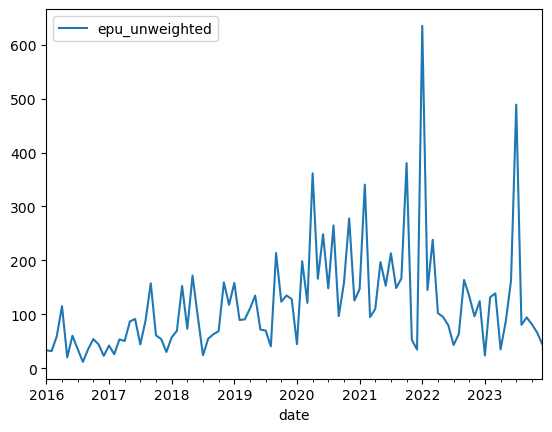

In [5]:
samoa_stats = e.epu_stats
samoa_stats.plot(x="date", y="epu_unweighted");

In [6]:
so = e.raw_files[1][1]
so[(so.date >= "2018-11-01") & (so.date < "2018-12-01") & so.epu]

,url,title,date,news,ym,econ,policy,uncertain,epu
17312,https://www.samoaobserver.ws/category/samoa/4058,Small Island States thankful for Samoa Pathway,2018-11-02,the chairman of the alliance of small island s...,2018-11,True,True,True,True
17314,https://www.samoaobserver.ws/category/samoa/4190,Firm celebrates one year anniversary,2018-11-02,fero samoa limited celebrated its one year ann...,2018-11,True,True,True,True
17333,https://www.samoaobserver.ws/category/samoa/5047,Surveying labour market essential for youth,2018-11-03,training providers should be offering short “c...,2018-11,True,True,True,True
17343,https://www.samoaobserver.ws/category/samoa/5277,Side-event focuses on gender and rights,2018-11-04,government officials from the region’s small i...,2018-11,True,True,True,True
17366,https://www.samoaobserver.ws/category/samoa/7875,Border security failure led to pandemic influenza,2018-11-06,the failure of samoa’s border security in the ...,2018-11,True,True,True,True
17372,https://www.samoaobserver.ws/category/samoa/7427,World Tsunami Awareness Day marked,2018-11-06,the disaster management office through the min...,2018-11,True,True,True,True
17407,https://www.samoaobserver.ws/category/samoa/11909,"“Sa’u was a bold, committed and fearless leader”",2018-11-10,"the minister of finance, sili epa tuioti, yest...",2018-11,True,True,True,True
17456,https://www.samoaobserver.ws/category/samoa/12141,Power and phone bills highlighted,2018-11-11,overspending by the ministry of health on elec...,2018-11,True,True,True,True
17476,https://www.samoaobserver.ws/category/samoa/15169,"Remittance cost high, says International Monet...",2018-11-13,"while some countries in the region, including ...",2018-11,True,True,True,True
17480,https://www.samoaobserver.ws/category/samoa/16935,Maiava welcomes Central Bank Governors,2018-11-14,"with the theme “strengthening collaboration”, ...",2018-11,True,True,True,True


In [7]:
#17m1-23m12
cpi_list = [
    104.4, 100.0, 99.6, 99.5, 100.2, 101.6, 103.4, 101.7, 101.3, 100.5, 100.2,
    101.0, 101.5, 101.6, 101.0, 100.7, 101.7, 102.6, 103.4, 104.3, 103.6,
    104.3, 105.0, 103.6, 110.3, 110.0, 108.8, 108.4, 111.6, 115.5, 115.6,
    114.7, 113.9, 113.8, 111.7, 108.6, 102.0, 104.8, 106.5, 106.1, 106.4,
    106.7, 108.4, 109.1, 109.4, 109.3, 109.0, 108.4, 109.7, 110.5, 111.0,
    107.9, 105.8, 104.9, 106.3, 107.0, 105.6, 103.6, 103.2, 103.4, 103.7,
    105.6, 107.1, 107.1, 107.7, 109.2, 111.0, 112.7, 112.8, 113.6, 113.0,
    115.3, 114.8, 115.3, 116.2, 117.2, 117.3, 121.0, 125.3, 129.9, 130.1,
    127.7, 124.6, 124.0, 128.2, 129.0, 129.8, 131.8, 131.5, 133.9, 134.0,
    132.8, 131.8, 132.3, 132.4, 132.0
]

In [8]:
cpi_df = pd.DataFrame(pd.date_range(start="2016-01-01",
                                    end="2023-12-01",
                                    freq="MS"),
                      columns=["date"])
cpi_df["cpi"] = cpi_list
cpi_df["inflation"] = cpi_df["cpi"].diff() * 100/ cpi_df["cpi"].shift(1)
cpi_df = cpi_df.merge(samoa_stats[["date", "epu_weighted", "epu_unweighted"]], how="left", on="date")
# cpi_df["epu_ma3"] = cpi_df["epu_weighted"].rolling(3).mean()
cpi_df["epu_diff"] = cpi_df["epu_weighted"].diff()
cpi_df.head(5)

,date,cpi,inflation,epu_weighted,epu_unweighted,epu_diff
0,2016-01-01,104.4,NaN,41.969713,33.508249,NaN
1,2016-02-01,100.0,-4.214559,41.639642,31.754007,-0.330070
2,2016-03-01,99.6,-0.400000,77.654730,59.456825,36.015087
3,2016-04-01,99.5,-0.100402,67.408696,115.251515,-10.246033
4,2016-05-01,100.2,0.703518,26.756202,20.314487,-40.652495


In [9]:
model_df = cpi_df.dropna()
get_adf_df(model_df, ["cpi", "inflation", "epu_weighted", "epu_unweighted","epu_diff"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value 1%,Critical Value 5%,Critical Value 10%
cpi,-0.578602,8.757442e-01,1.0,93.0,-3.502705,-2.893158,-2.583637
inflation,-8.051926,1.732780e-12,0.0,94.0,-3.501912,-2.892815,-2.583454
epu_weighted,-2.036704,2.707150e-01,4.0,90.0,-3.505190,-2.894232,-2.584210
epu_unweighted,-3.512987,7.659766e-03,2.0,92.0,-3.503515,-2.893508,-2.583824
epu_diff,-6.342774,2.728873e-08,6.0,88.0,-3.506944,-2.894990,-2.584615


In [10]:
import statsmodels.formula.api as smf
res = smf.ols("inflation~epu_unweighted",data=model_df)
res.fit(cov_type="HAC", cov_kwds={"maxlags":4}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inflation   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.693
Date:                Tue, 12 Mar 2024   Prob (F-statistic):              0.196
Time:                        14:46:01   Log-Likelihood:                -182.43
No. Observations:                  95   AIC:                             368.9
Df Residuals:                      93   BIC:                             374.0
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4866      0.247      1.970      0.049       0.003       0.971
epu_unweighted    -0.0019      0.001     -1.301      0.193      -0.005       0.001
==============================================================================
Omnibus:                       12.242   Durbin-Watson:                   1.486
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               38.163
Skew:                          -0.081   Prob(JB):                     5.16e-09
Kurtosis:                       6.101   Cond. No.                         244.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 4 lags and without small sample correction
"""

In [11]:
from statsmodels.tsa.api import VAR, ARDL

train = int(len(model_df) * 0.95)

model = VAR(model_df[["epu_diff", "inflation"]])
res = model.fit(ic="aic", trend='c')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 12, Mar, 2024
Time:                     14:46:11
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.31765
Nobs:                     92.0000    HQIC:                   9.08878
Log likelihood:          -658.044    FPE:                    7589.24
AIC:                      8.93390    Det(Omega_mle):         6553.96
--------------------------------------------------------------------
Results for equation epu_diff
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.797470         5.916664           -0.135           0.893
L1.epu_diff         -0.678240         0.105963           -6.401           0.000
L1.inflation        -1.340890         3.834969           -0.3

In [12]:
res.test_causality("inflation", "epu_diff").summary()

Test statistic,Critical value,p-value,df
3.155,2.658,0.026,"(3, 170)"


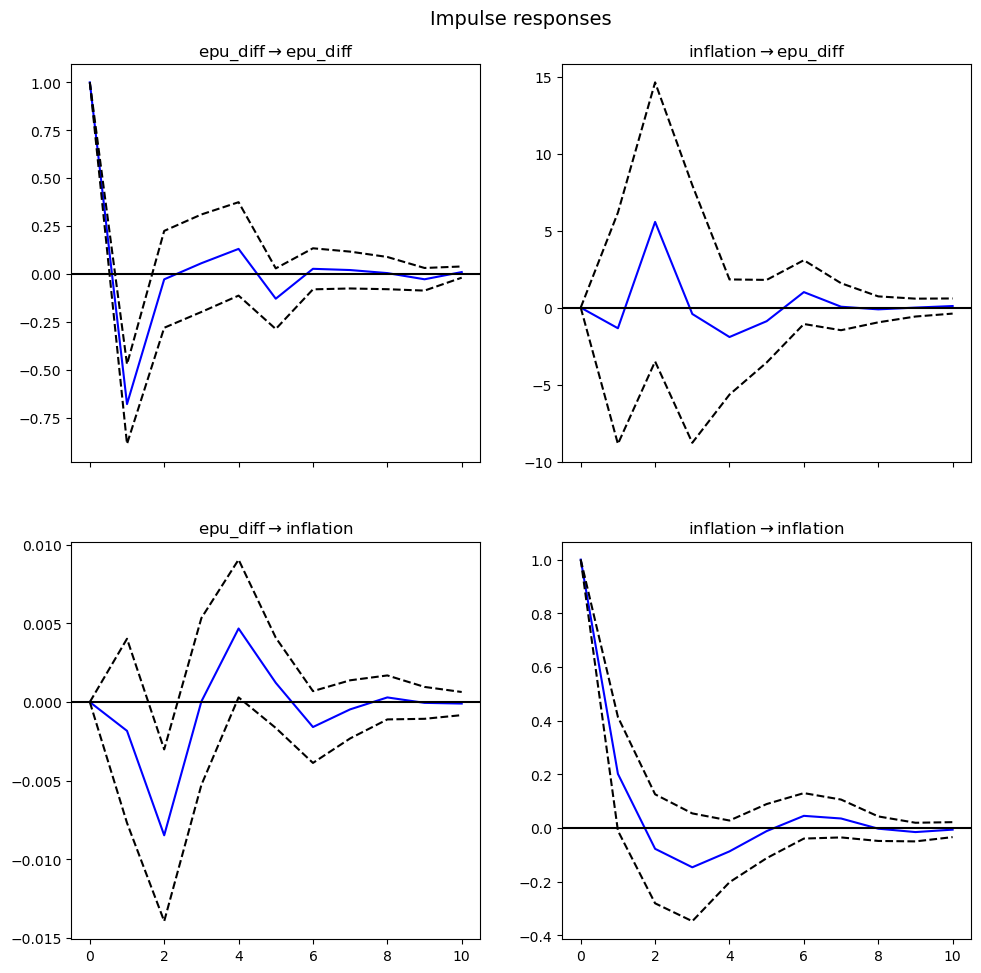

In [13]:
res.irf().plot();

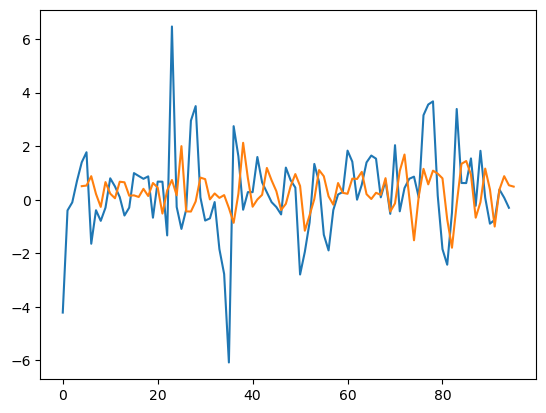

In [14]:
import matplotlib.pyplot as plt


plt.plot(model_df.inflation.values)
plt.plot(res.fittedvalues["inflation"]);

In [15]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

ardl_order = ardl_select_order(endog=model_df[['inflation']],
                               exog=model_df[['epu_weighted']],
                               maxlag=12,
                               maxorder=12)
ardl_res = ardl_order.model.fit()
ardl_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:              inflation   No. Observations:                   95
Model:                       ARDL(0,)   Log Likelihood                -183.033
Method:               Conditional MLE   S.D. of innovations              1.662
Date:                Tue, 12 Mar 2024   AIC                            370.066
Time:                        14:46:39   BIC                            375.174
Sample:                             0   HQIC                           372.130
                                   95                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2610      0.171      1.523      0.131      -0.079       0.601
==============================================================================
"""

In [16]:
max_lag = 10  # Set the maximum lag order to consider
res = select_order(model_df[["epu_weighted", "cpi"]].iloc[1:],
                   maxlags=max_lag,
                   deterministic='ci',
                   seasons=4)
optimal_order = res.selected_orders
rank_test = select_coint_rank(model_df[["epu_weighted", "cpi"]].iloc[1:],
                              1,
                              optimal_order["aic"],
                              method="trace",
                              signif=0.05)

# Fit VECM model with the determined order
model = VECM(model_df[["epu_weighted", "cpi"]].iloc[1:],
             k_ar_diff=optimal_order["aic"],
             coint_rank=rank_test.rank)
fitted_model = model.fit()

# Print the summary of the fitted model
print(fitted_model.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation epu_weighted
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.epu_weighted    -0.4550      0.136     -3.336      0.001      -0.722      -0.188
L1.cpi             -1.8247      3.221     -0.567      0.571      -8.137       4.488
L2.epu_weighted    -0.3375      0.125     -2.698      0.007      -0.583      -0.092
L2.cpi              3.9148      3.246      1.206      0.228      -2.448      10.277
L3.epu_weighted    -0.2256      0.107     -2.107      0.035      -0.435      -0.016
L3.cpi              0.1906      3.095      0.062      0.951      -5.875       6.256
 Det. terms outside the coint. relation & lagged endog. parameters for equation cpi
                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

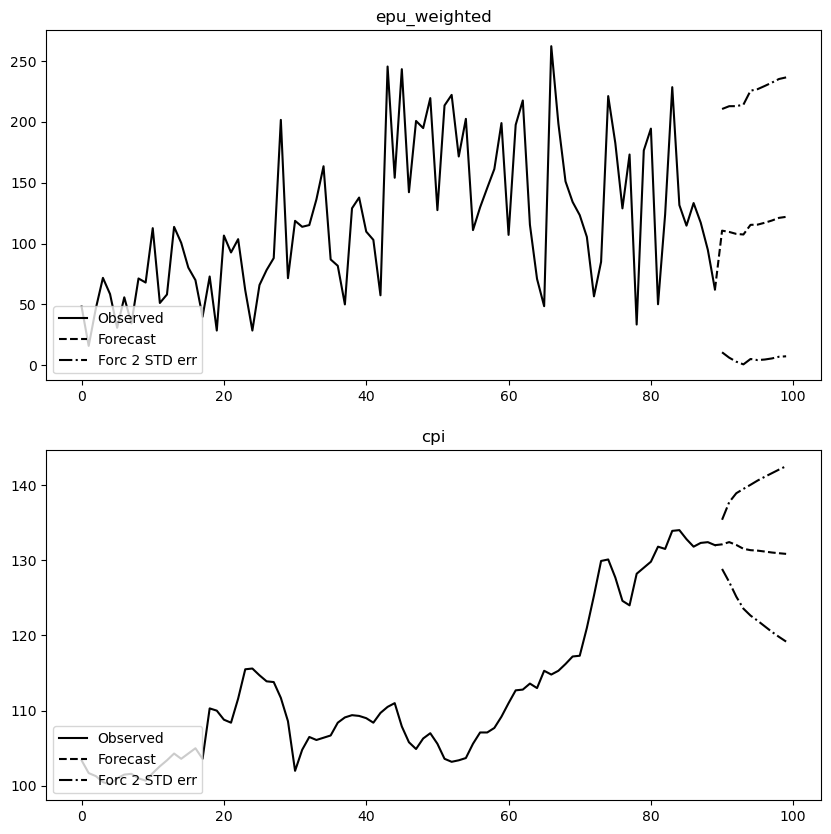

In [17]:
fitted_model.plot_forecast(steps=10)